In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as keras
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

In [21]:
# Dicts to identify which countries go with which tickers (all are 10-year Govt yields)
codes = {}
codes['US'] = 'USGG10YR'
codes['Germany'] = 'GDBR10'
codes['UK'] = 'GUKG10'
codes['France'] = 'GFRN10'
codes['Australia'] = 'GACGB10'
codes['Canada'] = 'GCAN10YR'
codes['New Zealand'] = 'GNZGB10'
codes['Japan'] = 'JGBS10'
codes['Switzerland'] = 'GSWISS10'
codes['Norway'] = 'GNOR10YR'
codes['Italy'] = 'GBTPGR10'

codes_back = {}
for key, value in codes.items():
    codes_back[value] = key

sheet_names = pd.ExcelFile('G10_RV.xlsx').sheet_names

# Combining data into single df
for i, x in enumerate(sheet_names[:11]):
    if i == 0:
        df = pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']]
        df.columns = ['Date', x]
    else:
        new_df = pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']]
        new_df.columns = ['Date', x]
        df = df.merge(new_df, on='Date', how='outer')

# Filling in missing days with previous observations, defining which columns are rates we want
df = df.set_index('Date')
df = df.resample('D').asfreq()
df = df.ffill()
df = df[::-1].dropna()
rates_tickers = df.columns[:11]

In [22]:
def simple(t):
    data = df[rates_tickers].copy()
    # Calculating our changes
    for ticker in data:
        data[f'{ticker}_c'] = data[ticker].diff(-t)

    #Train, test split
    data = data.dropna()
    changes = data[[x for x in data if x.endswith('_c')]]
    changes_training = changes[changes.index < '2023-1-1']
    changes_testing = changes[changes.index >= '2023-1-1']
    causalities = pd.DataFrame()
    causalities['Predictor'] = [codes_back[x] for x in rates_tickers] + ['', 'Training r2', 'Testing r2']

    # Building model and storing results for each rate as the target, making df to see results
    for i, target in enumerate(changes.columns):
        training_X = changes_training[[x for x in changes_training if x != target]]
        training_y = changes_training[target]
        testing_X = changes_testing[[x for x in changes_testing if x != target]]
        testing_y = changes_testing[target]
        model = LinearRegression()
        model.fit(training_X, training_y)
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_r2 = r2_score(training_y, training_prediction)
        testing_r2 = r2_score(testing_y, testing_prediction)
        coefficients = [round(x,2) for x in model.coef_]
        coefficients.insert(i, None)
        coefficients.insert(len(coefficients), '')
        coefficients.insert(len(coefficients), round(training_r2, 2))
        coefficients.insert(len(coefficients), round(testing_r2, 2))
        causalities[f'y: {codes_back[target[:-2]]}'] = coefficients
    causalities['ABS Mean'] = [causalities.iloc[i, 1:].dropna().abs().mean() for i in range(11)] + ['', '', '']
    
    return causalities

simple(100)

,Predictor,y: US,y: Germany,y: UK,y: France,y: Australia,y: Canada,y: New Zealand,y: Japan,y: Switzerland,y: Norway,y: Italy,ABS Mean
0,US,None,0.1,0.4,0.02,-0.09,0.5,0.11,0.11,-0.07,0.13,-0.14,0.167
1,Germany,0.2,None,0.46,0.6,0.1,0.01,-0.32,0.04,0.49,0.13,-0.64,0.299
2,UK,0.29,0.17,None,0.08,-0.06,-0.13,0.28,-0.01,-0.08,0.14,-0.32,0.156
3,France,0.03,0.43,0.16,None,0.16,-0.15,-0.01,0.08,0.07,0.05,2.19,0.333
4,Australia,-0.08,0.04,-0.07,0.1,None,0.29,0.61,-0.02,0.14,0.04,-0.28,0.167
5,Canada,0.54,0.01,-0.19,-0.12,0.36,None,0.05,-0.02,0.03,0.3,0.34,0.196
6,New Zealand,0.07,-0.11,0.25,-0.01,0.47,0.03,None,0.04,0.03,0.11,0.09,0.121
7,Japan,0.32,0.06,-0.06,0.16,-0.06,-0.05,0.17,None,0.13,-0.25,-0.17,0.143
8,Switzerland,-0.1,0.39,-0.16,0.08,0.26,0.04,0.08,0.07,None,0.12,-0.17,0.147
9,Norway,0.11,0.05,0.16,0.03,0.03,0.23,0.14,-0.07,0.06,None,-0.21,0.109


In [23]:
t_values = [1,5,10,25,50,100]

def multi(target, t):
    target_t = f'{target}_{t}'
    data = df[rates_tickers].copy()
    # Adding changes for each t value we specified for every ticker
    for ticker in rates_tickers:
        for x in t_values:
            data[f'{ticker}_{x}'] = data[ticker].diff(-x)

    #Training model and storing predictions and performance. Too many predictors to make clean df
    data = data.dropna()
    data_training = data[data.index < '2023-1-1'].copy()
    data_testing = data[data.index >= '2023-1-1'].copy()
    training_X = data_training[[x for x in data_training if '_' in x and x != target_t]]
    training_y = data_training[target_t]
    testing_X = data_testing[[x for x in data_testing if '_' in x and x != target_t]]
    testing_y = data_testing[target_t]
    model = LinearRegression()
    model.fit(training_X, training_y)
    testing_prediction = model.predict(testing_X)
    r2 = round(r2_score(testing_y, testing_prediction),2)
    data_testing['c_prediction'] = testing_prediction
    prediction = data_testing[[target, target_t, 'c_prediction']].copy()
    prediction['prediction'] = prediction[target].shift(-t) + prediction['c_prediction']
    prediction = prediction[[target, 'prediction']].dropna()
    return prediction, r2

In [24]:
t_values = [1,5,10,25,50,100]

def nn_multi(target, t):
    target_t = f'{target}_{t}'
    data = df[rates_tickers].copy()
    for ticker in rates_tickers:
        for x in t_values:
            data[f'{ticker}_{x}'] = data[ticker].diff(-x)
    data = data.dropna()
    data_training = data[data.index < '2023-1-1'].copy()
    data_testing = data[data.index >= '2023-1-1'].copy()
    training_X = data_training[[x for x in data_training if '_' in x and x != target_t]]
    training_y = data_training[target_t]
    testing_X = data_testing[[x for x in data_testing if '_' in x and x != target_t]]
    testing_y = data_testing[target_t]
    scaler = StandardScaler()
    training_X = scaler.fit_transform(training_X)
    testing_X = scaler.transform(testing_X)

    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=[training_X.shape[1]]),
            Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            Dropout(0.3),
            tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    model.fit(training_X, training_y, epochs=200, validation_split=0.2, callbacks=[early_stopping])
    testing_prediction = model.predict(testing_X)
    r2 = round(r2_score(testing_y, testing_prediction), 2)
    data_testing['c_prediction'] = testing_prediction
    prediction = data_testing[[target, target_t, 'c_prediction']].copy()
    prediction['prediction'] = prediction[target].shift(-t) + prediction['c_prediction']
    prediction = prediction[[target, 'prediction']].dropna()
    return prediction, r2

In [25]:
def t_eval(t):
    r2s = pd.DataFrame()
    r2s['Target'] = list(codes.keys())
    r2s['r2: Simple'] = r2s['Target'].apply(lambda x: simple(t)[f'y: {x}'][13])
    r2s['r2: Multi NN'] = r2s['Target'].apply(lambda x: nn_multi(codes[x], t)[1])
    r2s['r2: Multi'] = r2s['Target'].apply(lambda x: multi(codes[x], t)[1])
    r2s = r2s.set_index('Target')
    simple_mean = round(r2s['r2: Simple'].mean(), 2)
    multi_mean = round(r2s['r2: Multi'].mean(), 2)
    nn_mean = round(r2s['r2: Multi NN'].mean(), 2)
    r2s.loc['Mean'] = {'r2: Simple': simple_mean, 'r2: Multi': multi_mean, 'r2: Multi NN': nn_mean}
    return r2s

t_eval(10)

Epoch 1/200
117/117 [==============================] - 0s 1ms/step - loss: 0.3503 - val_loss: 0.0426
Epoch 2/200
117/117 [==============================] - 0s 999us/step - loss: 0.0798 - val_loss: 0.0235
Epoch 3/200
117/117 [==============================] - 0s 906us/step - loss: 0.0365 - val_loss: 0.0173
Epoch 4/200
117/117 [==============================] - 0s 765us/step - loss: 0.0240 - val_loss: 0.0140
Epoch 5/200
117/117 [==============================] - 0s 766us/step - loss: 0.0199 - val_loss: 0.0130
Epoch 6/200
117/117 [==============================] - 0s 737us/step - loss: 0.0138 - val_loss: 0.0117
Epoch 7/200
117/117 [==============================] - 0s 688us/step - loss: 0.0129 - val_loss: 0.0114
Epoch 8/200
117/117 [==============================] - 0s 690us/step - loss: 0.0106 - val_loss: 0.0100
Epoch 9/200
117/117 [==============================] - 0s 703us/step - loss: 0.0098 - val_loss: 0.0099
Epoch 10/200
117/117 [==============================] - 0s 754us/step - los

,r2: Simple,r2: Multi NN,r2: Multi
Target,,,
US,0.86,0.91,0.94
Germany,0.94,0.96,0.97
UK,0.72,0.84,0.89
France,0.98,0.96,0.99
Australia,0.78,0.87,0.90
Canada,0.82,0.90,0.92
New Zealand,0.73,0.82,0.87
Japan,0.21,0.59,0.67
Switzerland,0.62,0.81,0.83


In [26]:
performances = pd.DataFrame()
performances['Target'] = list(codes.keys())

for t in t_values:
    performances[str(t)] = performances['Target'].apply(lambda x: multi(codes[x], t)[1])

performances = performances.set_index('Target')
performances.loc['Mean'] = round(performances.mean(),2)
performances

,1,5,10,25,50,100
Target,,,,,,
US,0.84,0.92,0.94,0.93,0.93,0.85
Germany,0.94,0.97,0.97,0.97,0.98,0.95
UK,0.76,0.88,0.89,0.84,0.77,0.67
France,0.98,0.99,0.99,0.99,0.98,0.98
Australia,0.67,0.84,0.90,0.90,0.85,0.71
Canada,0.83,0.90,0.92,0.90,0.93,0.92
New Zealand,0.60,0.81,0.87,0.84,0.86,0.83
Japan,0.37,0.62,0.67,0.65,0.68,0.48
Switzerland,0.71,0.84,0.83,0.80,0.79,0.54


##### Develop trading strategy for given rate

In [27]:
def trader(name, t, threshold):
    target = codes[name]
    data, r2 = multi(target, t)
    data['spread'] = data['prediction'] - data[target]
    data['signal'] = 0
    data.loc[data['prediction'] - threshold > data[target], 'signal'] = 1
    data.loc[data['prediction'] < data[target] - threshold, 'signal'] = -1
    data['signal'] = data['signal'].shift(1)
    data['tar_return'] = data[target].diff(-1)
    data['sig_return'] = data['tar_return'] * data['signal']
    data['cum_return'] = data['sig_return'][::-1].cumsum()
    data = data.dropna()
    final_return = round(list(data['cum_return'])[0], 3)
    flats = data['signal'].value_counts()[0]
    return data, r2, flats, final_return

In [28]:
def analysis(t, threshold):
    analysis = pd.DataFrame()
    analysis['Target'] = list(codes.keys())
    analysis['r2'] = analysis['Target'].apply(lambda x: trader(x, t, threshold)[1])
    analysis['flats'] = analysis['Target'].apply(lambda x: trader(x, t, threshold)[2])
    analysis['final_return'] = analysis['Target'].apply(lambda x: trader(x, t, threshold)[3])
    analysis = analysis.set_index('Target')
    return analysis

results = analysis(100, .01)
results

,r2,flats,final_return
Target,,,
US,0.85,13,1.793
Germany,0.95,35,-1.427
UK,0.67,8,-1.997
France,0.98,50,1.348
Australia,0.71,6,1.081
Canada,0.92,18,-2.060
New Zealand,0.83,16,-0.867
Japan,0.48,25,-0.358
Switzerland,0.54,21,-0.048


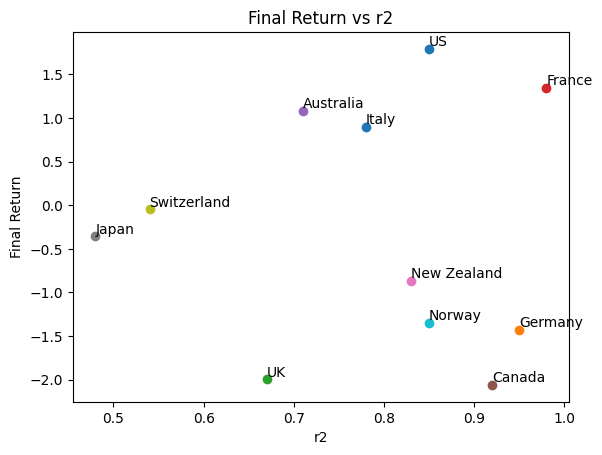

In [29]:
# What makes the strategy work for some countries but not for others?

for idx, row in results.iterrows():
    plt.scatter(row['r2'], row['final_return'])
    plt.text(row['r2'], row['final_return'], str(idx), ha='left', va='bottom')

plt.title('Final Return vs r2')
plt.xlabel('r2')
plt.ylabel('Final Return')
plt.show()